In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Used to display images in a specific colormap
from scipy.io import loadmat

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 7.0)
np.set_printoptions(suppress=True) # Don't print scietific numbers form

# 1 Anomaly detection

In [2]:
data1 = loadmat('ex8/ex8data1.mat')
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
def plot_data(X):   
    plt.plot(  data1['X'][:,0], data1['X'][:,1], 'bx', markersize = 3.5 )
    plt.axis([0,30,0,30])
    plt.xlabel( 'Latency (ms)' )
    plt.ylabel( 'Throughput (mb/s)' )

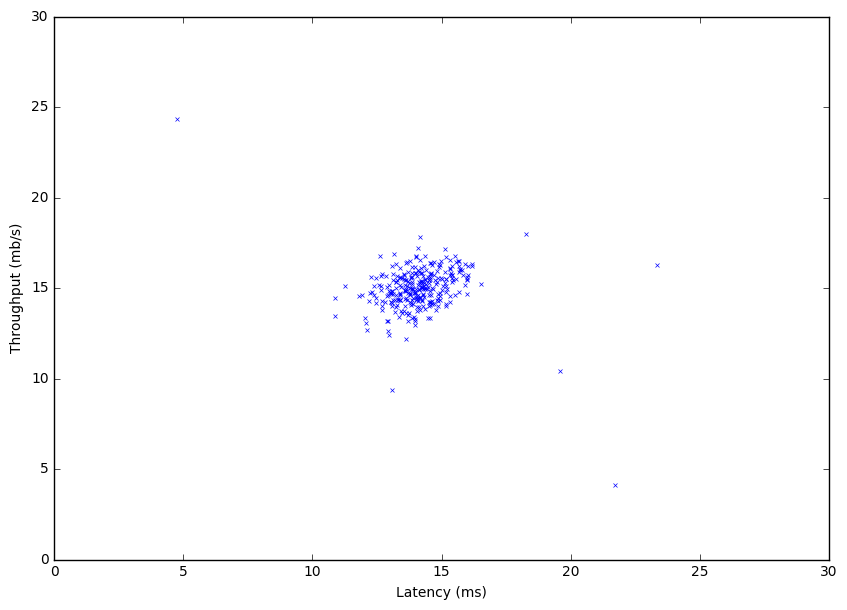

In [4]:
plot_data(data1['X'])

1.1 Gaussian distribution

Given a training set $\{X^{(1)},...,x^{(m)} \} $ (where $X^{(i)} \in \mathbb{R}^n$), we estimate the Gaussian distribution for each feature $x_i$. For each of the features $i = 1,...,n$ we find parameters $\mu_i$ and $\sigma^{2}_i$ that fit the data in the $i$-th dimension, where $\mu$ is the mean and $\sigma^2$ controls the variance. 

The Gaussian distribution is given by


$$ p(x; \mu, \sigma) = \frac{1}{2\pi\sigma^2}\exp(- \frac{(x - \mu)^2}{2\sigma^2})~. $$ 
 
The parameters $(\mu_i, \sigma_i)$ are defined by 

$$ \mu_i = \frac{1}{m}\sum_{j=1}^{m}x_{i}^{j}~, $$
$$ \sigma_i^2 = \frac{1}{m}\sum_{j=1}^{m} ( x_{i}^{j} - \mu_i )^2 ~.$$ 

1.2 Estimating parameters for a Gaussian

In [5]:
def estimate_gaussian(X):
    return X.mean(axis=0), np.cov(X.T)

In [6]:
mu, sigma2 = estimate_gaussian(data1['X'])

In [7]:
def mva_gaussian( X, mu, sigma2 ):
    k = len(mu)
    # check if sigma2 is a vector and, if yes, use as the diagonal of the covariant matrix
    if sigma2.ndim == 1 :
        sigma2 = np.diag(sigma2)
    X = X - mu
    return (2 * np.pi)**(-k/2) * np.linalg.det(sigma2)**(-0.5) * \
        np.exp( -0.5 * np.sum( np.multiply( X.dot( np.linalg.inv(sigma2) ), X ), axis=1 ) ).reshape( ( X.shape[0], 1 ) )

In [8]:
# Check dimensionality
p = mva_gaussian(data1['X'], mu, sigma2)
print(p.shape)

(307, 1)


In [9]:
def visualize_fit( X, mu, sigma2 ):
    x = y = np.arange( 0, 30, 0.5 )
    xx, yy = np.meshgrid( x, y )
    z = mva_gaussian( np.vstack( (xx.ravel(), yy.ravel()) ).T, mu, sigma2 )
    z = z.reshape( xx.shape )
    levels = [ 10**a for a in range(-20, 0, 3) ]
    plt.contour( xx, yy, z, levels=levels )

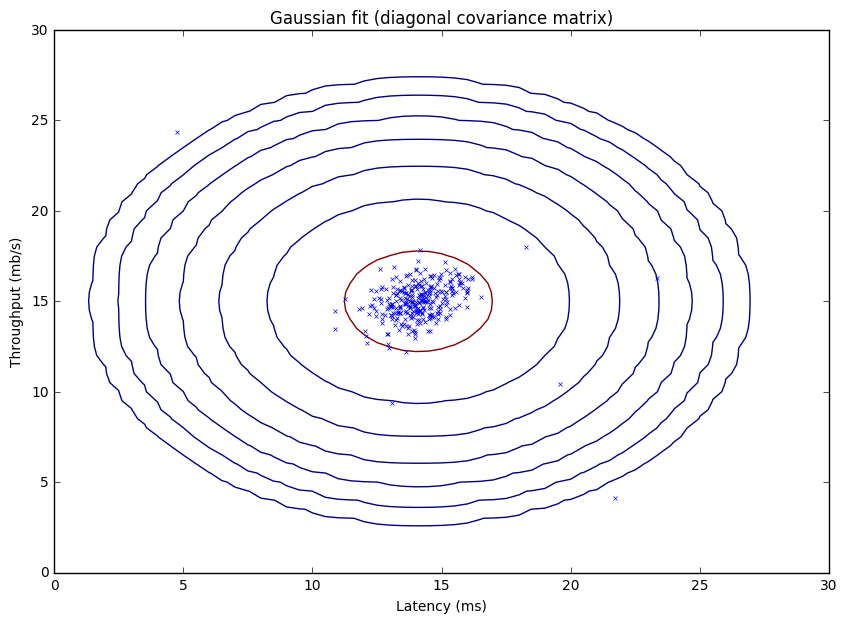

In [10]:
plot_data(data1['X'])
visualize_fit(data1['X'], mu , np.diag( sigma2) )
plt.title( 'Gaussian fit (diagonal covariance matrix)' )

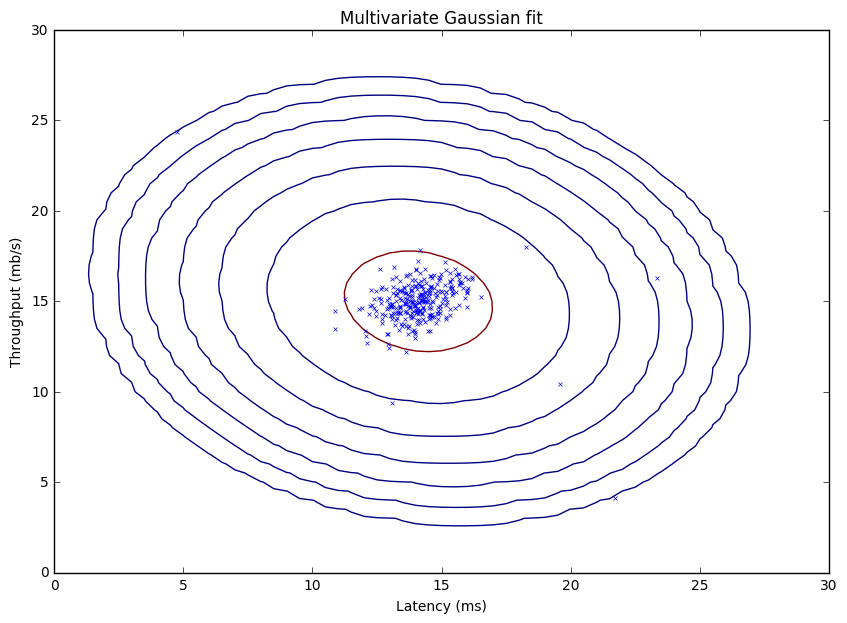

In [11]:
plot_data(data1['X'])
visualize_fit(data1['X'], mu , sigma2)
plt.title('Multivariate Gaussian fit')

1.3 Selecting the threshold, $\epsilon$

The $F_1$ score is computed using precision ($prec$) and recall ($rec$):

$$ F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}~, $$

where

$$ prec = \frac{tp}{tp + fp}~, $$

$$rec \frac{tp}{tp+fn}~. $$

In [12]:
def select_threshold( yval, pval ):
    best_Epsilon = 0
    best_F1 = 0
    
    for eps in np.linspace( np.amin(pval), np.amax(pval), 1000 ):
        cv_predictions = pval < float(eps)

        if len( cv_predictions ) < 1:
            continue
            
        tp = np.sum( np.logical_and( (cv_predictions == 1), (yval == 1) ) )
        fp = np.sum( np.logical_and( (cv_predictions == 1), (yval == 0) ) )
        fn = np.sum( np.logical_and( (cv_predictions == 0), (yval == 1) ) )

        prec = tp/(tp + fp)
        rec = tp/(tp + fn)
        F1 = (2 * prec * rec) / ( prec + rec )
        if F1 > best_F1:
            best_F1 = F1
            best_Epsilon = float(eps)

    return best_Epsilon, best_F1

In [13]:
pval = mva_gaussian( data1['Xval'], mu, sigma2 )

In [14]:
epsilon, f1 = select_threshold( data1['yval'], pval )

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in long_scalars


In [15]:
outliers = mva_gaussian( data1['X'], mu, sigma2 )[:,0] < epsilon

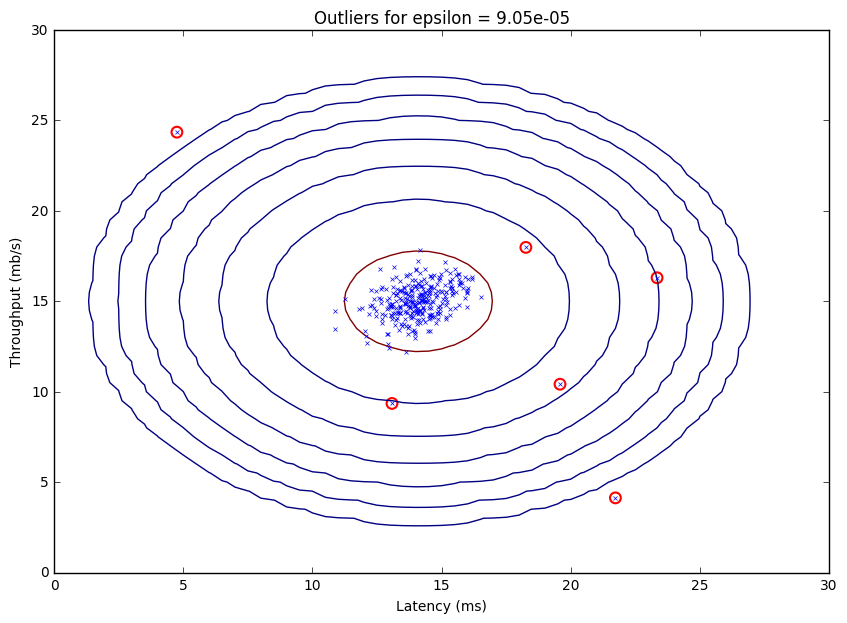

In [16]:
width = 1
precision = 3
plot_data(data1['X'])
visualize_fit(data1['X'], mu , np.diag( sigma2) )
plt.title( f'Outliers for epsilon = {epsilon:{width}.{precision}}' ) # python 3.6 formatted string literals
plt.scatter( data1['X'][outliers][:,0], data1['X'][outliers][:,1], s=60, edgecolors='r', facecolors='None', linewidth=1.5 )

1.4 High dimensional dataset

In [17]:
hd_data = loadmat('ex8/ex8data2.mat')
hd_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [18]:
mu_hd, sigma2_hd = estimate_gaussian( hd_data['X'] )

In [19]:
p_hd = mva_gaussian( hd_data['X'], mu_hd, np.diag(sigma2_hd) )

In [20]:
pval_hd = mva_gaussian( hd_data['Xval'], mu_hd, np.diag(sigma2_hd) )

In [21]:
epsilon_hd, f1_hd = select_threshold(hd_data['yval'], pval_hd)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in long_scalars


In [22]:
print( 'Best epsilon found using cross-validation: ', epsilon_hd )
print( 'Best F1 on Cross Validation Set:', f1_hd )
print( '# of outliers found: ', np.sum( p_hd < epsilon_hd ) )

Best epsilon found using cross-validation:  1.3730337086887016e-18
Best F1 on Cross Validation Set: 0.615384615385
# of outliers found:  117


# 2 Recommender Systems

In [23]:
movies_data = loadmat('ex8/ex8_movies.mat')
movies_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

2.1 Movie ratings dataset

In [24]:
# n_u = 943 users, n_m = 1682 movies
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
# rating to movie i

# From the matrix, we can compute statistics like average rating.

print('Average rating for movie 1 (Toy Story): ', round( np.mean( movies_data['Y'][0][movies_data['R'][0].astype(bool)] ), 2 ))

Average rating for movie 1 (Toy Story):  3.88


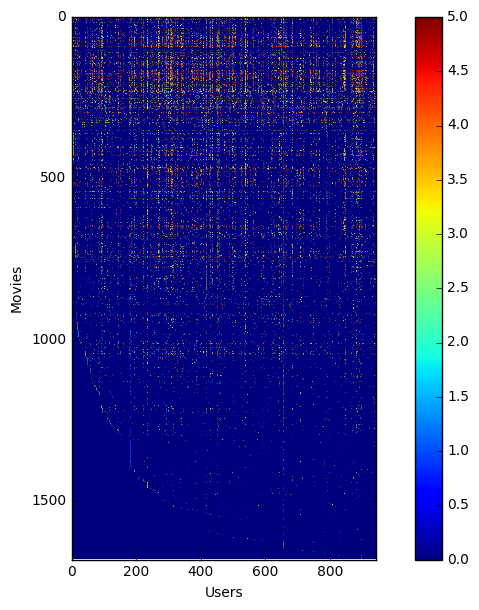

In [25]:
# We can "visualize" the ratings matrix by plotting it with imagesc
plt.imshow( movies_data['Y'] )
plt.colorbar()
plt.xlabel('Users')
plt.ylabel('Movies')

2.2 Collaborative filtering learning algorithm

2.2.1 Collaborative filtering cost function

The collaborative filtering cost function (without regularization) is given by

$$ J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_U)}) = \frac{1}{2}\sum_{(i,j):r(i,j)=1} ((\theta^{(j)})^{T}x^{(i)} - y^{(i,j)})^2 ~.  $$

In [26]:
def cofi_cost_func( params, Y, R, num_users, num_movies, num_features, lmda ):
    # Unfold back the parameters to X and Theta
    X = params[:num_movies*num_features].reshape( (num_movies, num_features) )
    Theta = params[num_movies*num_features:].reshape( (num_users, num_features) )
   
    X_grad = np.zeros( (X.shape) )
    Theta_grad = np.zeros( (Theta.shape) )
    
    J = np.sum(np.square( np.multiply( X.dot(Theta.T) - Y, R ) )) / 2
    X_grad = np.multiply( X.dot(Theta.T) - Y, R ).dot(Theta) + lmda * X
    Theta_grad = np.multiply( X.dot(Theta.T) - Y, R ).T.dot(X) + lmda * Theta
    
    reg_x = (lmda/2) * np.sum( np.square(X) ) 
    reg_theta = (lmda/2) * np.sum( np.square(Theta) ) 
    
    return ( J + reg_x + reg_theta, np.concatenate( ( X_grad.ravel(), Theta_grad.ravel() ) ) )

In [27]:
movie_params = loadmat('ex8/ex8_movieParams.mat')
movie_params.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [28]:
#  Reduce the data set size so that this runs faster (as in the matlab script)
num_users = 4 
num_movies = 5 
num_features = 3

X = movie_params['X'][0:num_movies, 0:num_features]
Theta = movie_params['Theta'][0:num_users, 0:num_features]
Y = movies_data['Y'][0:num_movies, 0:num_users]
R = movies_data['R'][0:num_movies, 0:num_users]

In [29]:
J, grad = cofi_cost_func( np.concatenate(( X.ravel(), Theta.ravel() )), Y, R, num_users, num_movies, num_features, 0 )
print(J)

22.2246037257


2.2.2 Collaborative filtering gradient

The gradients of the cost function are given by:

$$ \frac{\partial J}{\partial x_{k}^{(i)} } = \sum_{j:r(i,j)=1} ((\theta^{(j)})^{T}x^{(i)} - y^{(i,j)})\theta_{k}^{(j)} ~,$$

$$ \frac{\partial J}{\partial \theta_{k}^{(j)} } = \sum_{i:r(i,j)=1} ((\theta^{(j)})^{T}x^{(i)} - y^{(i,j)})x_{k}^{(i)} ~.$$


In [30]:
# The gradients are implemented in the cofi_cost_func function

2.2.3 Regularized cost function

The cost function for collaborative filtering with regularization is given by

$$ J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_U)}) = \frac{1}{2}\sum_{(i,j):r(i,j)=1} ((\theta^{(j)})^{T}x^{(i)} - y^{(i,j)})^2 +\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^{n}(\theta_{k}^{(j)})^2 + \frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^{n}(x_{k}^{(i)})^2 ~.  $$


In [31]:
J, grad = cofi_cost_func( np.concatenate(( X.ravel(), Theta.ravel() )), Y, R, num_users, num_movies, num_features, 1.5 )
print( 'Cost with lambda = 1.5: ', round( J, 2 ) )

Cost with lambda = 1.5:  31.34


2.2.4 Regularized gradient

The gradients for the regularized cost function is given by:

$$ \frac{\partial J}{\partial x_{k}^{(i)} } = \sum_{j:r(i,j)=1} ((\theta^{(j)})^{T}x^{(i)} - y^{(i,j)})\theta_{k}^{(j)} +\lambda x_{k}^{(i)} ~,$$

$$ \frac{\partial J}{\partial \theta_{k}^{(j)} } = \sum_{i:r(i,j)=1} ((\theta^{(j)})^{T}x^{(i)} - y^{(i,j)})x_{k}^{(i)} + \lambda\theta_{k}^{(j)} ~.$$

2.3 Learning movie recommendations

In [32]:
from scipy.optimize import minimize

In [33]:
# Assign a list with the movies indices and corresponding names
movie_idx = []
f = open('ex8/movie_ids.txt' , encoding = "ISO-8859-1") 
# You might need to change the encoding (try removing the argument first if it doesn't work)
for line in f:
    tmp = line.split( ' ', 1 )
    movie_idx.append( tmp[1].splitlines()[0] )

print(movie_idx[0:4])

['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', 'Get Shorty (1995)']


In [34]:
# Additional user ratings (given in the exercise)
my_ratings = np.zeros((1682,1))
my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [35]:
# The column to be added to the R matrix is:
my_ratings_R = my_ratings > 0

In [36]:
Y = np.c_[ movies_data['Y'], my_ratings ]
R = np.c_[ movies_data['R'], my_ratings_R ]
print(Y.shape)
print(R.shape)

(1682, 944)
(1682, 944)


In [37]:
def normalize_ratings( Y, R ):
    # Taking into account only rated movies
    Y_mean = np.sum( Y, axis=1 ) / np.sum( R, axis=1 )
    Y_mean = Y_mean.reshape( ( Y_mean.shape[0], 1) )
    
    return Y - Y_mean, Y_mean

In [38]:
#  Useful Values
Y_norm, Y_mean = normalize_ratings( Y, R )

num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

In [39]:
# Random initialization
X = np.random.randn( num_movies, num_features )
Theta = np.random.randn( num_users, num_features )

initial_params = np.concatenate( (X.ravel(), Theta.ravel()) )

lmda = 10
theta = minimize( fun = cofi_cost_func, x0 = initial_params, 
              args = (Y_norm, R, num_users, num_movies, num_features, lmda), 
              method = 'CG', jac = True, options = {'maxiter' : 100} )

In [40]:
theta

     fun: 38958.933843075196
     jac: array([-0.41548513, -0.12863646, -0.11683711, ..., -0.00317754,
        0.00643223, -0.00454381])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 149
     nit: 100
    njev: 149
  status: 1
 success: False
       x: array([ 0.47591795,  0.08322705,  0.17780235, ..., -0.04067168,
       -0.0874526 ,  0.1382125 ])

In [41]:
# unfold the training result back into the X and Theta matrices
X = theta.x[:num_movies*num_features].reshape( (num_movies, num_features) )
Theta = theta.x[num_movies*num_features:].reshape( (num_users, num_features) )

# Check dimensions are correct
print(X.shape, Theta.shape)

(1682, 10) (944, 10)


In [42]:
# Need to add Y_mean to the predictions matrix, in order to get the predictions 
# for a specific user (in this case we consider the user that "added his ratings").
# We should also sort the user's predictions
pred = X.dot(Theta.T)
my_pred = pred[:,-1].reshape( (pred.shape[0], 1) ) + Y_mean

my_pred_sorted = np.sort(my_pred, axis=0)[::-1]

# As sorting changes the order, we need to keep track of the indices, 
# to associate each rating with the correct movie
my_pred_idx = np.argsort(my_pred, axis=0)[::-1]

# Print the top ten ratings and the corresponding movie indices
print(my_pred_sorted[:10])
print(my_pred_idx[:10])

[[ 5.00000054]
 [ 5.00000044]
 [ 5.00000024]
 [ 5.00000008]
 [ 4.99999996]
 [ 4.99999995]
 [ 4.99999985]
 [ 4.99999969]
 [ 4.99999952]
 [ 4.99999253]]
[[1292]
 [1652]
 [1535]
 [1466]
 [1188]
 [1121]
 [1598]
 [1200]
 [1499]
 [ 813]]


In [43]:
print('Top recommendations for you:')
# This is python 3.6 formatted string literals:
width = 1
precision = 2
for i in range(10):
    rating = my_pred[int(my_pred_idx[i])][0]
    name = movie_idx[int(my_pred_idx[i])]
    print (f'Predicting rating {rating:{width}.{precision}} for movie {name}')
    
print('\nOriginal ratings provided:')
for i in range( len(my_ratings) ):
    if my_ratings[i] > 0:
        print (f'Rated {int(my_ratings[i])} for movie {movie_idx[i]}')

Top recommendations for you:
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)

Original ratings provided:
Rated 4 for movie Toy Story (1995)
Rated 3 for movie Twelve Monkeys (1995)
Rated 5 for movie Usual Suspects, The (1995)
Rated 4 for movie Outbreak (1995)
Rated 5 for movie Shawshank Redemption, The (1994)
Rated 3 for movie While You Were Sleeping (1995)
Rated 5 for movie Forrest Gump (1994)
Rated 2 for movie Silence of

# Repeating the minimization with Y instead of Y_norm looks much more similar to the output shown in the exercise text 

In [44]:
# Random initialization
X = np.random.randn( num_movies, num_features )
Theta = np.random.randn( num_users, num_features )

initial_params = np.concatenate( (X.ravel(), Theta.ravel()) )

lmda = 10
theta = minimize( fun = cofi_cost_func, x0 = initial_params, 
              args = (Y, R, num_users, num_movies, num_features, lmda), 
              method = 'CG', jac = True, options = {'maxiter' : 100} )

In [45]:
theta

     fun: 72112.87945832995
     jac: array([-1.75098795, -5.17947431, -4.88952184, ...,  0.00079039,
        0.07835285,  0.00390344])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 151
     nit: 100
    njev: 151
  status: 1
 success: False
       x: array([-0.35427484,  1.16404322,  1.02235876, ...,  0.52713845,
        0.75681484, -0.61494577])

In [46]:
# unfold the training result back into the X and Theta matrices
X = theta.x[:num_movies*num_features].reshape( (num_movies, num_features) )
Theta = theta.x[num_movies*num_features:].reshape( (num_users, num_features) )

# Check dimensions are correct
print(X.shape, Theta.shape)

(1682, 10) (944, 10)


In [47]:
# Need to add Y_mean to the predictions matrix, in order to get the predictions 
# for a specific user (in this case we consider the user that "added his ratings").
# We should also sort the user's predictions
pred = X.dot(Theta.T)
my_pred = pred[:,-1].reshape( (pred.shape[0], 1) ) + Y_mean

my_pred_sorted = np.sort(my_pred, axis=0)[::-1]

# As sorting changes the order, we need to keep track of the indices, 
# to associate each rating with the correct movie
my_pred_idx = np.argsort(my_pred, axis=0)[::-1]

# Print the top ten ratings and the corresponding movie indices
print(my_pred_sorted[:10])
print(my_pred_idx[:10])

[[ 8.64033375]
 [ 8.51689224]
 [ 8.39887987]
 [ 8.29553887]
 [ 8.21368864]
 [ 8.17695668]
 [ 8.13146087]
 [ 8.09804925]
 [ 8.02721234]
 [ 8.02024777]]
[[ 49]
 [312]
 [ 63]
 [173]
 [271]
 [317]
 [171]
 [ 11]
 [407]
 [180]]


In [48]:
print('Top recommendations for you:')
# This is python 3.6 formatted string literals:
width = 1
precision = 2
for i in range(10):
    rating = my_pred[int(my_pred_idx[i])][0]
    name = movie_idx[int(my_pred_idx[i])]
    print (f'Predicting rating {rating:{width}.{precision}} for movie {name}')
    
print('\nOriginal ratings provided:')
for i in range( len(my_ratings) ):
    if my_ratings[i] > 0:
        print (f'Rated {int(my_ratings[i])} for movie {movie_idx[i]}')

Top recommendations for you:
Predicting rating 8.6 for movie Star Wars (1977)
Predicting rating 8.5 for movie Titanic (1997)
Predicting rating 8.4 for movie Shawshank Redemption, The (1994)
Predicting rating 8.3 for movie Raiders of the Lost Ark (1981)
Predicting rating 8.2 for movie Good Will Hunting (1997)
Predicting rating 8.2 for movie Schindler's List (1993)
Predicting rating 8.1 for movie Empire Strikes Back, The (1980)
Predicting rating 8.1 for movie Usual Suspects, The (1995)
Predicting rating 8.0 for movie Close Shave, A (1995)
Predicting rating 8.0 for movie Return of the Jedi (1983)

Original ratings provided:
Rated 4 for movie Toy Story (1995)
Rated 3 for movie Twelve Monkeys (1995)
Rated 5 for movie Usual Suspects, The (1995)
Rated 4 for movie Outbreak (1995)
Rated 5 for movie Shawshank Redemption, The (1994)
Rated 3 for movie While You Were Sleeping (1995)
Rated 5 for movie Forrest Gump (1994)
Rated 2 for movie Silence of the Lambs, The (1991)
Rated 4 for movie Alien (197